# Time Series Clustering with K-Means and Dynamic Time Warping for total (n2)


----
**Specification of experiment:**
- scripted trips only
- n2 column of acceleration data was used
- Dynamic Time Warping with L1 Norm was calculated

-----
**Results:**

1) KMeans Clustering with 3 Clusters:


    Estimated number of clusters: 3

    True number of clusters: 3*

    Homogeneity: 0.700

    Completeness: 0.510

    V-measure: 0.590

    Adjusted MI: 0.509

    Silhouette Coefficient: 0.854


*Assume that transport modes are true clusters

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import plot_3D




%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels
%aimport features.build_features
from features.build_features import calculate_maximum_break_length
from features.build_features import calculate_maximum_acceleration_length
%aimport models.cluster
from models.cluster import get_clustering_performance

In [2]:
# Set to true if all trips should be plotted at the end
plot_all_trips = False

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]
scripted_trips_only = trips_cut_per_30_sec[trips_cut_per_30_sec["scripted"] == 1]
scripted_trips_only = scripted_trips_only.reset_index(drop=True)

dtw_path = os.path.join(data_dir, "preprocessed","preprocessed_data_dtw.csv")

distance_matrix = pd.read_csv(dtw_path,sep=";")
distance_matrix = distance_matrix[distance_matrix["scripted"] == 1]
distance_matrix = distance_matrix.reset_index(drop=True)

In [4]:
print("shape:",distance_matrix.shape)
display(distance_matrix.head(5))

shape: (1004, 1929)


,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,distance_9,...,distance_1919,distance_1920,distance_1921,distance_1922,distance_1923,mode,notes,scripted,token,trip_id
0,0.000000,1212.613220,1320.151034,1236.639983,1014.886123,1228.550639,1357.918243,1435.655030,1158.220454,1358.429901,...,2572.012278,2874.638549,2210.631736,1486.698252,1264.583278,WALK,scripted,1,355007075245007,0
1,1212.613220,0.000000,924.720541,1207.060406,931.758987,1026.793363,1104.038224,1319.927062,1261.686634,1209.295356,...,2305.691063,1883.025609,2138.711017,1630.366750,1244.643061,WALK,scripted,1,355007075245007,0
2,1320.151034,924.720541,0.000000,1164.051288,1078.988125,1247.796417,1224.342338,1276.705365,1215.811772,1720.049019,...,2341.435728,2506.562704,2224.825095,1529.234448,1455.535498,WALK,scripted,1,355007075245007,0
3,1236.639983,1207.060406,1164.051288,0.000000,991.716270,1107.677436,1641.144597,1430.648421,1138.473062,1407.094084,...,2156.518728,2498.446323,2007.477069,1547.638507,1267.586742,WALK,scripted,1,355007075245007,0
4,1014.886123,931.758987,1078.988125,991.716270,0.000000,1250.263705,1184.103597,1165.162902,1175.128568,1222.256508,...,2426.365374,1922.661558,2039.409396,1436.329932,1261.132808,WALK,scripted,1,355007075245007,0


### Choose which features to use

In [5]:
features_used = distance_matrix

### Prepare features for clustering

In [6]:
features_used = features_used.drop(categorical_columns,axis=1)
features_used = pd.DataFrame(scale(features_used),columns=features_used.columns)
features_used.head(2)

,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,distance_9,...,distance_1914,distance_1915,distance_1916,distance_1917,distance_1918,distance_1919,distance_1920,distance_1921,distance_1922,distance_1923
0,-7.326516,-2.143653,-1.870527,-2.215624,-3.069808,-2.728076,-1.847647,-1.679273,-2.786191,-2.176715,...,-0.942852,-0.593024,-0.972929,-1.141288,-1.587338,-0.437932,1.211984,-1.208264,-1.982211,-1.707543
1,-2.348366,-7.613928,-3.853016,-2.342095,-3.448682,-3.737447,-2.993211,-2.322706,-2.410141,-2.766706,...,-1.689504,-1.374093,-1.532979,-1.235964,-0.506487,-1.267416,-3.129042,-1.421860,-1.111737,-1.845078


------
# Model Building

## Create Model with Clustering by KMeans

Use summaries of each distance

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced = pd.DataFrame(pca.fit_transform(features_used))


features_used = reduced
print("Explained Variance Ratio:",pca.explained_variance_ratio_)

Explained Variance Ratio: [ 0.76473965  0.15871489  0.02918918]


In [8]:
from sklearn.cluster import KMeans
random_state = 0

kmeans = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = kmeans.labels_
distance_matrix["cluster_labels"]=cluster_labels

## Plot with PCA

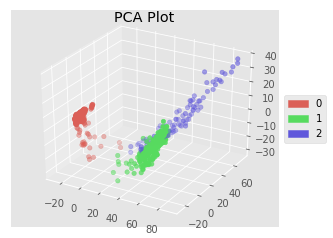

In [9]:
colors,color_patches = get_color_encoding(cluster_labels)
plot_3D(reduced.iloc[:,0],reduced.iloc[:,1],reduced.iloc[:,2], colors, color_patches,title="PCA Plot with cluster labels")


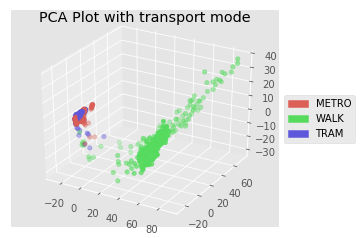

In [16]:
colors,color_patches = get_color_encoding(distance_matrix["mode"])
plot_3D(reduced.iloc[:,0],reduced.iloc[:,1],reduced.iloc[:,2], colors, color_patches,title="PCA Plot with transport mode")


-----
## Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [10]:
cluster_performance = get_clustering_performance(features_used, cluster_labels,
                                                 true_labels=distance_matrix["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.700

 - Completeness: 0.510

 - V-measure: 0.590

 - Adjusted MI: 0.509

 - Silhouette Coefficient: 0.854

## Visualise Clustering on 2D - TSNE Plot:

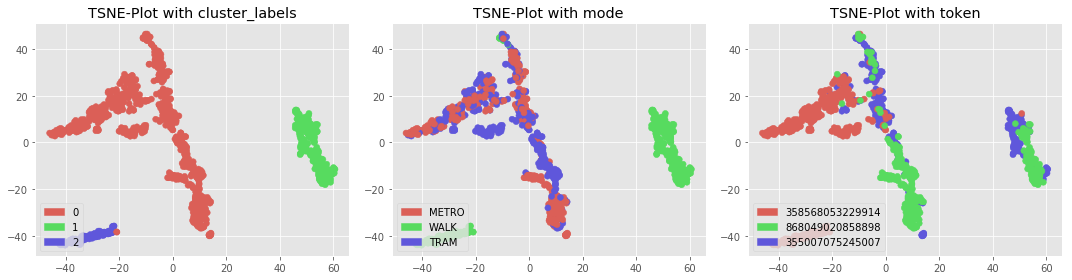

In [11]:
color_encodings = distance_matrix.loc[:,["cluster_labels","mode","token"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings)

## Inspect the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [12]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,mode
0,12.0,201.0,99.0,WALK
1,359.0,0.0,0.0,TRAM
2,333.0,0.0,0.0,METRO


### Plot distribution of cluster labels for transport modes

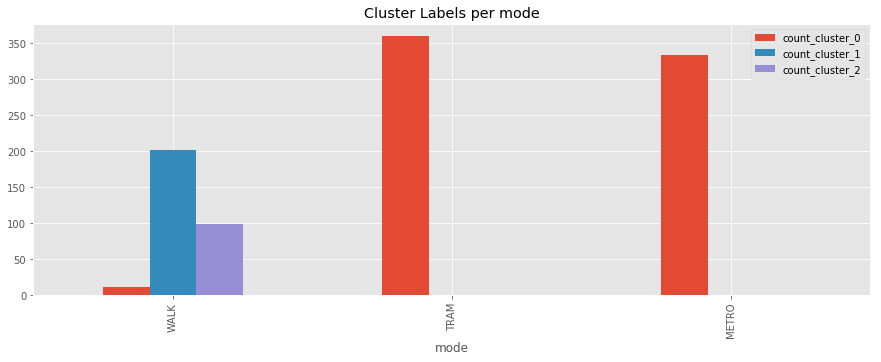

In [13]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for tokens

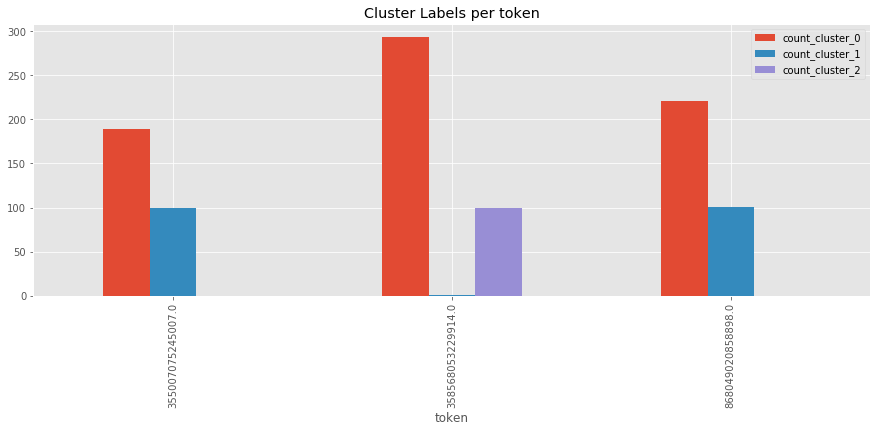

In [14]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

------
## Plot all trips with their clustering labels

In [15]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, distance_matrix)